# Predicting bird species with random forests
used Caltech-UCSD Birds-200-2011 (CUB-200-2011) http://www.vision.caltech.edu/datasets/cub_200_2011/


#### what it is
- an ensamble of decision trees
- each tree is allowed to look at some of the atributes
- each tree is specialized to said atributes
- whichever outcome gets the most votes from the ensamble, 'wins'

#### when to use
- when there is a sufficient number of attributes to make trees
- when accuracy is paramount
- dont use if interpretability is important 
- dont use on resource limited enviorments


In [1]:
# imports
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import itertools
import numpy as np
# %matplotlib qt

In [2]:
# read the image attributes from txt format into dataframe
img_atts = pd.read_csv('C:/Users/fksas/ML_practice/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt',
                      sep='\s+', header=None, error_bad_lines=False, warn_bad_lines=False,
                      usecols=[0,1,2], names=['imgid', 'attid', 'present']
                     
                     )
img_atts

imgid  attid  present
0            1      1        0
1            1      2        0
2            1      3        0
3            1      4        0
4            1      5        1
...        ...    ...      ...
3677851  11788    308        1
3677852  11788    309        0
3677853  11788    310        0
3677854  11788    311        0
3677855  11788    312        1

[3677856 rows x 3 columns]

In [3]:
# organize the dataset to be useful
# one row per imgid
# cloumns should be attid
# value in columns should be set through the present column
img_atts = img_atts.pivot(index='imgid', columns='attid', values='present')
img_atts

attid  1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
1        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
5        0    0    0    0    1    0    0    0    0    0  ...    0    0    1   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11784    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
11785    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
11786    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
11787    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
11788    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   

attid  306  307  308  309  310  311  312  
imgid                                     
1        0    0    1    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    1    0    0    1    0  
4        1    0    0    1    0    0    0  
5        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
11784    1    0    0    1    0    0    0  
11785    1    0    1    0    0    0    0  
11786    0    0    1    0    0    1    0  
11787    0    0    0    0    0    1    0  
11788    1    0    1    0    0    0    1  

[11788 rows x 312 columns]

In [4]:
# read labels from txt format to dataframe
labels = pd.read_csv('C:/Users/fksas/ML_practice/CUB_200_2011/CUB_200_2011/image_class_labels.txt',
                     sep=' ', header=None, names=['imgid', 'label'])
labels = labels.set_index('imgid')
labels

label
imgid       
1          1
2          1
3          1
4          1
5          1
...      ...
11784    200
11785    200
11786    200
11787    200
11788    200

[11788 rows x 1 columns]

In [5]:
# join both img_atts and labels, and shuffle the rows
dataset = img_atts.join(labels)
dataset = dataset.sample(frac=1)
dataset

1  2  3  4  5  6  7  8  9  10  ...  304  305  306  307  308  309  310  \
imgid                                 ...                                      
11374  0  0  0  0  0  0  1  0  0   0  ...    0    0    0    0    0    0    0   
11228  0  1  0  0  0  0  0  0  0   0  ...    0    0    0    1    0    0    0   
488    0  0  0  0  0  0  0  1  0   0  ...    0    1    0    0    0    0    0   
4542   0  0  1  0  0  0  0  0  0   0  ...    0    0    0    0    0    1    0   
1714   0  0  0  0  0  0  1  0  0   0  ...    0    0    0    0    1    1    0   
...   .. .. .. .. .. .. .. .. ..  ..  ...  ...  ...  ...  ...  ...  ...  ...   
5235   0  0  0  0  0  1  0  0  0   0  ...    0    1    0    0    0    0    0   
7046   0  0  0  0  0  0  0  1  0   0  ...    0    0    0    0    0    0    0   
10917  0  0  0  0  0  0  0  0  1   0  ...    0    0    0    0    1    0    0   
9729   0  0  0  0  0  0  1  0  0   0  ...    0    0    0    0    0    0    0   
7137   0  0  0  0  0  0  0  1  0   0  ...    0    1    0    0    0    0    0   

       311  312  label  
imgid                   
11374    1    0    194  
11228    0    1    191  
488      0    0     10  
4542     0    0     78  
1714     0    0     31  
...    ...  ...    ...  
5235     0    1     90  
7046     1    0    121  
10917    0    1    186  
9729     0    1    166  
7137     1    0    122  

[11788 rows x 313 columns]

In [6]:
# split the dataset into X(attributes) and y(labels)
att = dataset.iloc[:, :312]
label = dataset.iloc[:, 312:]
att
label

1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
11374    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
11228    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
488      0    0    0    0    0    0    0    1    0    0  ...    0    0    1   
4542     0    0    1    0    0    0    0    0    0    0  ...    0    0    0   
1714     0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5235     0    0    0    0    0    1    0    0    0    0  ...    0    0    1   
7046     0    0    0    0    0    0    0    1    0    0  ...    0    0    0   
10917    0    0    0    0    0    0    0    0    1    0  ...    0    0    0   
9729     0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
7137     0    0    0    0    0    0    0    1    0    0  ...    0    0    1   

       306  307  308  309  310  311  312  
imgid                                     
11374    0    0    0    0    0    1    0  
11228    0    1    0    0    0    0    1  
488      0    0    0    0    0    0    0  
4542     0    0    0    1    0    0    0  
1714     0    0    1    1    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
5235     0    0    0    0    0    0    1  
7046     0    0    0    0    0    1    0  
10917    0    0    1    0    0    0    1  
9729     0    0    0    0    0    0    1  
7137     0    0    0    0    0    1    0  

[11788 rows x 312 columns]

label
imgid       
11374    194
11228    191
488       10
4542      78
1714      31
...      ...
5235      90
7046     121
10917    186
9729     166
7137     122

[11788 rows x 1 columns]

In [7]:
# train test split (8000, 4000)
X_train = att[:8000]
y_train = label[:8000]

X_test = att[8000:]
y_test = label[8000:]

#turn to a series like
y_train = y_train['label']
y_test = y_test['label']

X_train
y_train
X_test
y_test

1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
11374    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
11228    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
488      0    0    0    0    0    0    0    1    0    0  ...    0    0    1   
4542     0    0    1    0    0    0    0    0    0    0  ...    0    0    0   
1714     0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9993     0    0    0    0    0    0    0    1    0    0  ...    0    0    0   
2699     0    0    0    0    0    0    0    1    0    0  ...    0    0    1   
10463    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
1413     0    0    0    0    0    0    1    0    0    0  ...    0    0    1   
1476     0    0    0    0    0    0    1    0    0    0  ...    0    0    0   

       306  307  308  309  310  311  312  
imgid                                     
11374    0    0    0    0    0    1    0  
11228    0    1    0    0    0    0    1  
488      0    0    0    0    0    0    0  
4542     0    0    0    1    0    0    0  
1714     0    0    1    1    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
9993     0    0    0    1    0    0    0  
2699     0    0    0    1    0    0    0  
10463    0    0    1    1    0    0    0  
1413     0    0    0    1    0    0    0  
1476     0    0    0    0    0    0    0  

[8000 rows x 312 columns]

imgid
11374    194
11228    191
488       10
4542      78
1714      31
        ... 
9993     170
2699      47
10463    178
1413      26
1476      27
Name: label, Length: 8000, dtype: int64

1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
7963     0    0    0    1    0    0    0    0    0    0  ...    0    0    0   
2724     0    0    0    0    0    0    0    1    0    0  ...    0    0    1   
9311     0    0    0    0    0    0    1    0    0    0  ...    0    0    1   
6968     0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
6770     0    0    0    0    0    0    0    1    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5235     0    0    0    0    0    1    0    0    0    0  ...    0    0    1   
7046     0    0    0    0    0    0    0    1    0    0  ...    0    0    0   
10917    0    0    0    0    0    0    0    0    1    0  ...    0    0    0   
9729     0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
7137     0    0    0    0    0    0    0    1    0    0  ...    0    0    1   

       306  307  308  309  310  311  312  
imgid                                     
7963     0    0    0    0    1    0    0  
2724     0    0    0    0    0    0    0  
9311     0    0    0    0    0    1    0  
6968     0    0    0    1    0    0    0  
6770     0    0    1    0    0    1    0  
...    ...  ...  ...  ...  ...  ...  ...  
5235     0    0    0    0    0    0    1  
7046     0    0    0    0    0    1    0  
10917    0    0    1    0    0    0    1  
9729     0    0    0    0    0    0    1  
7137     0    0    0    0    0    1    0  

[3788 rows x 312 columns]

imgid
7963     136
2724      48
9311     159
6968     119
6770     116
        ... 
5235      90
7046     121
10917    186
9729     166
7137     122
Name: label, Length: 3788, dtype: int64

In [8]:
# build classifier
model = RandomForestClassifier(n_estimators=100, max_features=50, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(max_features=50, random_state=0)

In [9]:
model.score(X_test,y_test)

0.4585533262935586

In [10]:
# utility to view confusion matrix
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('COnfusion matrix, without normalization')
        
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    plt.tight_layout()
    plt.ylabel("True")
    plt.xlabel('Predicted')

In [11]:
# building confusion matrix
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[ 4,  2,  2, ...,  0,  0,  0],
       [ 1, 15,  0, ...,  0,  0,  0],
       [ 2,  1,  9, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  0,  5,  0],
       [ 0,  0,  0, ...,  0,  0, 13]], dtype=int64)

In [12]:
# label names
birds = pd.read_csv('C:/Users/fksas/ML_practice/CUB_200_2011/CUB_200_2011/classes.txt',
                   sep='\s+', header=None, usecols=[1], names=["birdname"])
birds = birds["birdname"]
birds

0      001.Black_footed_Albatross
1            002.Laysan_Albatross
2             003.Sooty_Albatross
3           004.Groove_billed_Ani
4              005.Crested_Auklet
                  ...            
195                196.House_Wren
196                197.Marsh_Wren
197                 198.Rock_Wren
198               199.Winter_Wren
199       200.Common_Yellowthroat
Name: birdname, Length: 200, dtype: object

In [13]:
np.set_printoptions(precision=2)
plt.figure(figsize=(60,60), dpi=300)
plot_confusion_matrix(confusion_mat, birds, normalize=True)
plt.show()

<Figure size 18000x18000 with 0 Axes>

Normalized confusion matrix
[[0.22 0.11 0.11 ... 0.   0.   0.  ]
 [0.04 0.65 0.   ... 0.   0.   0.  ]
 [0.11 0.05 0.47 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.04 ... 0.08 0.   0.  ]
 [0.   0.   0.   ... 0.   0.29 0.  ]
 [0.   0.   0.   ... 0.   0.   0.81]]


In [14]:
#hyper parameter testing
max_feature_opts = range(5,50,5)
n_estimators_opts = range(10, 200, 20)
rf_params = np.empty((len(max_feature_opts)*len(n_estimators_opts),4),float)
i = 0

for max_features in max_feature_opts:
    for n_estimators in n_estimators_opts:
        model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        rf_params[i,0] = max_features
        rf_params[i,1] = n_estimators
        rf_params[i,2] = scores.mean()
        rf_params[i,3] = scores.std() * 2
        i += 1
        print(f'Max features: {max_features},\
                num estimators: {n_estimators},\
                accuracy: {round(scores.mean(),2)} (+/-{scores.std() * 2})')

Max features: 5,                num estimators: 10,                accuracy: 0.25 (+/-0.012574776339959315)
Max features: 5,                num estimators: 30,                accuracy: 0.35 (+/-0.01941970648593847)
Max features: 5,                num estimators: 50,                accuracy: 0.38 (+/-0.006864765108873024)
Max features: 5,                num estimators: 70,                accuracy: 0.4 (+/-0.024718414188616568)
Max features: 5,                num estimators: 90,                accuracy: 0.41 (+/-0.019277577648657007)
Max features: 5,                num estimators: 110,                accuracy: 0.42 (+/-0.013014415084820366)
Max features: 5,                num estimators: 130,                accuracy: 0.43 (+/-0.008909264840602718)
Max features: 5,                num estimators: 150,                accuracy: 0.43 (+/-0.023138171924333168)
Max features: 5,                num estimators: 170,                accuracy: 0.43 (+/-0.009797958971132706)
Max features: 5,          

Max features: 40,                num estimators: 130,                accuracy: 0.44 (+/-0.009400797838481571)
Max features: 40,                num estimators: 150,                accuracy: 0.44 (+/-0.009637167633698212)
Max features: 40,                num estimators: 170,                accuracy: 0.44 (+/-0.011973930014828039)
Max features: 40,                num estimators: 190,                accuracy: 0.44 (+/-0.012144957801491127)
Max features: 45,                num estimators: 10,                accuracy: 0.33 (+/-0.01815557765536533)
Max features: 45,                num estimators: 30,                accuracy: 0.4 (+/-0.010577097900653093)
Max features: 45,                num estimators: 50,                accuracy: 0.42 (+/-0.013290033860002003)
Max features: 45,                num estimators: 70,                accuracy: 0.42 (+/-0.006051859218455124)
Max features: 45,                num estimators: 90,                accuracy: 0.43 (+/-0.01497915217894526)
Max features: 45, 

(0.2, 0.5)

Text(0.5, 0, 'Max features')

Text(0.5, 0, 'Num estimators')

Text(0.5, 0, 'Avg accuracy')

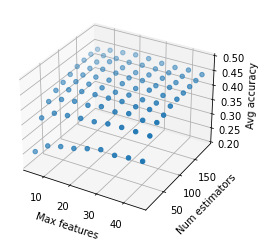

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
fig.clf()
ax = fig.gca(projection='3d')
x = rf_params[:,0]
y = rf_params[:,1]
z = rf_params[:,2]
ax.scatter(x,y,z)
ax.set_zlim(0.2, 0.5)
ax.set_xlabel('Max features')
ax.set_ylabel('Num estimators')
ax.set_zlabel('Avg accuracy')
plt.show()